In [1]:
# Python >= 3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn >= 0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    !pip install -q -U tfx==0.21.2
    print("You can safely ignore the package incompatibility errors.")
except Exception:
    pass

# TensorFlow >= 2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

import numpy as np
import soundfile as sf
import os
import glob
import tqdm
import json
import librosa
from librosa import display
from pathlib import Path
import IPython.display as pd
import matplotlib.pyplot as plt

In [2]:
from scipy.ndimage.filters import maximum_filter1d
from copy import deepcopy
import numpy as np
import joblib
import os
import csv
from madmom.io import midi
import warnings

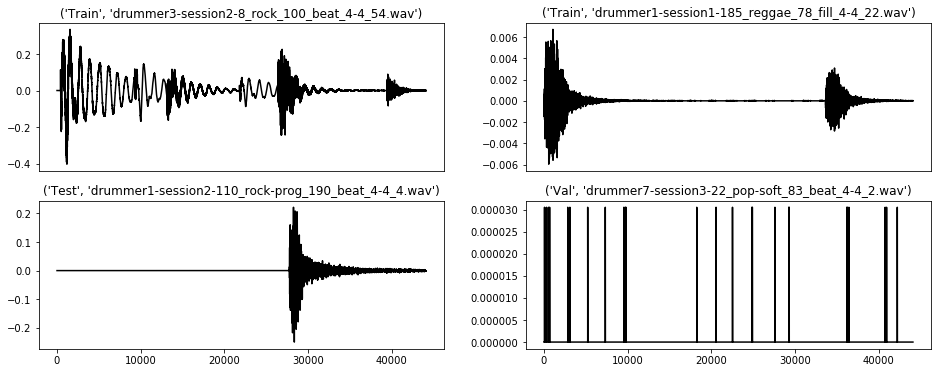

In [3]:
# get all wav files
fps = glob.glob('/Volumes/Ext_SSD/e-gmd-v1.0.0/**/*.wav', recursive=True)
fps_random = []
np.random.seed()

# setup subplot 
nrows, ncols = 2, 2
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 6))

# plot some audio waveforms
for r in range(nrows):
    for c in range(ncols):
        fp_random = fps[np.random.randint(len(fps))]
        audio, sr = librosa.core.load(fp_random, duration=1,sr=None)
        ax[r][c].plot(audio, c='k')
        # ax[r][c].axis('off')
        ax[r][c].set_title(Path(fp_random).parts[-2:])
        if r == 0:
            ax[r][c].set_xticks([])
        # save random audio filepaths
        fps_random.append(fp_random)

In [4]:
# 7 hits from the original paper
classes = ['KD','SD','TT','HH','CY','RD','BE']

# best-practice: write down your preprocessing config in a dictonary
config = {'sr': 16000, 
          'audio_length': 1,  # in seconds
          'mono': True,
          'n_mels': 64,  # number bins / vertical resolution
          'n_fft': 2048,  # 2048 samples for fft
          'hop_length': 441, # shift to the right / frames with 10ms width
          'win_length': 2048,
          'window': 'hann',
          'center': True,
          'pad_mode': 'reflect',
          'power': 2.0,
          'classes': classes
         }

# save number of frames from length in samples divided by fft hop length
config['n_frames'] = int(config['sr']*config['audio_length']/config['hop_length']) + 1
print(f'config["n_frames"]: {config["n_frames"]}')

# save input shape for model
config['input_shape'] = (config['n_frames'], config['n_mels'],  1)
print(f'config["input_shape"]: {config["input_shape"]}')

# save config 
with open('/Volumes/Ext_SSD/e-gmd-v1.0.0/e-gmd.json', 'w+') as fp:
    json.dump(config, fp, sort_keys=True, indent=4)

# pretty print json
print(json.dumps(config, indent=4))

config["n_frames"]: 37
config["input_shape"]: (37, 64, 1)
{
    "sr": 16000,
    "audio_length": 1,
    "mono": true,
    "n_mels": 64,
    "n_fft": 2048,
    "hop_length": 441,
    "win_length": 2048,
    "window": "hann",
    "center": true,
    "pad_mode": "reflect",
    "power": 2.0,
    "classes": [
        "KD",
        "SD",
        "TT",
        "HH",
        "CY",
        "RD",
        "BE"
    ],
    "n_frames": 37,
    "input_shape": [
        37,
        64,
        1
    ]
}


16000
16000
16000
16000
Melspec shape: (64, 37)
Stft shape: (1025, 37)
Total data points in mel-spectrogram: 2368
Total data points in stft-spectrogram: 37925
-> Data Reduction by factor: 16.015625



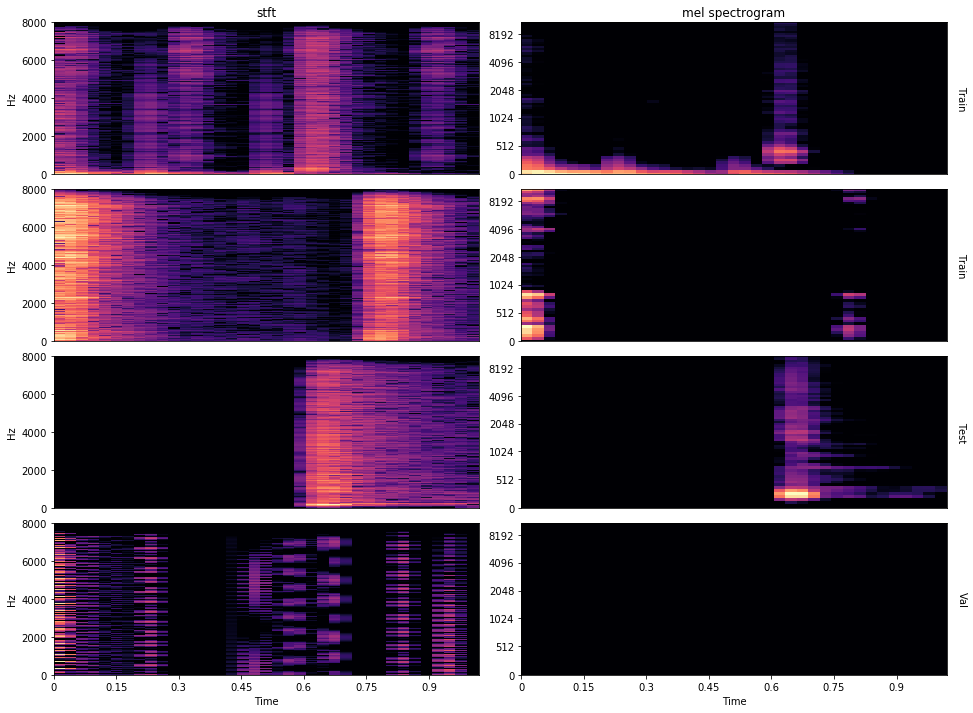

In [5]:
# setup subplot 
nrows, ncols = 4, 2
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 12))

# plot some audio waveforms
for i, fp_random in enumerate(fps_random):
    audio, sr = librosa.core.load(fp_random, duration=1,sr=config['sr'])
    print(sr)
    # calculate stft
    stft = librosa.stft(audio, n_fft=config['n_fft'], hop_length=config['hop_length'], win_length=config['win_length'])
    
    # calculate melspec
    melspec = librosa.feature.melspectrogram(audio, n_fft=config['n_fft'], hop_length=config['hop_length'], win_length=config['win_length'], n_mels=config['n_mels'], fmax=int(config['sr']/2))
    melspec = librosa.amplitude_to_db(melspec, ref=np.max)

    # calculate magnitude and scale to dB
    magspec = librosa.amplitude_to_db(np.abs(stft), ref=np.max)

    # plot with librosa
    librosa.display.specshow(magspec, x_axis='time', y_axis='linear', sr=config['sr'], hop_length=config['hop_length'], ax=ax[i][0])
    librosa.display.specshow(melspec, x_axis='time', y_axis='mel', sr=config['sr'], hop_length=config['hop_length'], ax=ax[i][1])
    
    # adjustments
    # ax[i][1].set_yticks([])
    ax[i][1].set_ylabel(Path(fp_random).parts[-2], rotation=270, labelpad=20)
    ax[i][1].yaxis.set_label_position("right")
    
    # settings for all axises but bottom ones
    if not i == len(fps_random) - 1:
        ax[i][0].set_xticks([])
        ax[i][1].set_xticks([])
        ax[i][0].set_xlabel('')
        ax[i][1].set_xlabel('')
    
    # settings for upper axises
    if i == 0:
        ax[i][0].set_title('stft')
        ax[i][1].set_title('mel spectrogram')   

# adjust whitespace in between subplots        
plt.subplots_adjust(hspace=0.1, wspace=0.1)

print('Melspec shape: %s' % (str(melspec.shape)))
print('Stft shape: %s' % (str(stft.shape)))
print(f'Total data points in mel-spectrogram: {melspec.shape[0]*melspec.shape[1]}')
print(f'Total data points in stft-spectrogram: {stft.shape[0]*stft.shape[1]}')
print(f'-> Data Reduction by factor: {(stft.shape[0]*stft.shape[1]) / (melspec.shape[0]*melspec.shape[1])}')
print()

In [6]:
midi_file_path = glob.glob('/Volumes/Ext_SSD/e-gmd-v1.0.0/**/*.midi', recursive=True)

In [7]:
pattern = midi.MIDIFile(midi_file_path[3])

print(midi_file_path[15])
#print(type(pattern.notes))
#pattern.notes[1]

/Volumes/Ext_SSD/e-gmd-v1.0.0/Test/drummer1-eval_session-10_soul-groove10_102_beat_4-4_24.midi


In [8]:
#drum mapping dictionary
drum_mapping={
          36: 0, #kick
          38: 1, #snare head
          40: 2, #snare rim
          37: 3, #snare x-stick
          48: 4, #tom1
          50: 5, #tom1_rim
          45: 6, #tom2
          47: 7, #tom2_rim
          43: 8, #tom3_head
          58: 9, #tom3_rim
          46: 10,#hhopen_bow
          26: 11,#hhopen_edge
          42: 12,#hhclosed_bow
          
          22: 13,#hhclosed_edge
          44: 14,#hhpedal
          49: 15,#crash1_bow
          55: 16,#crash1_edge
          57: 17,#crash2_bow
          52: 18,#crash2_edge
          51: 19,#ride_bow          
          59: 20,#ride_edge
          53: 21,#ride_bell
          
          39: 22,#clap
          54: 23,#tambourine
          56: 24,#cowbell
          70: 25,#maracas
          64: 26,#low_conga
          75: 27 #claves
         }

# save config 
with open('/Volumes/Ext_SSD/e-gmd-v1.0.0/e-gmd.json', 'w+') as fp:
    json.dump(drum_mapping, fp, sort_keys=True, indent=4)

# pretty print json
print(json.dumps(drum_mapping, indent=4))


{
    "36": 0,
    "38": 1,
    "40": 2,
    "37": 3,
    "48": 4,
    "50": 5,
    "45": 6,
    "47": 7,
    "43": 8,
    "58": 9,
    "46": 10,
    "26": 11,
    "42": 12,
    "22": 13,
    "44": 14,
    "49": 15,
    "55": 16,
    "57": 17,
    "52": 18,
    "51": 19,
    "59": 20,
    "53": 21,
    "39": 22,
    "54": 23,
    "56": 24,
    "70": 25,
    "64": 26,
    "75": 27
}


In [9]:
#get ground thruth
def get_y_from_file(midifile, n_frames):
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        pattern = midi.MIDIFile(midifile)
        dt = float(config['hop_length']) / float(config['sr'])       
        
        y_onsets = np.zeros((n_frames, len(drum_mapping)), dtype=np.uint8) #28 instruments deswegen 28-1 
        
        i=0
        for note in pattern.notes:
            instrument=int(note[1])  #1st value in array is for instrument type
            label=drum_mapping[instrument]

            note_start = int(np.round(note[0] / dt)) # 0. value in array is the onset
            #note_end = int(np.round(note[0] + note[2] / dt)) # 2. value in array the duration
            #print(instrument)
            #print(note_start)
            i=i+1
            
            if note_start < n_frames:
                y_onsets[note_start, label] = 1
            
            else:
                print('Offset > n_frames reached')
                break

        return y_onsets

In [10]:
#print onset i[0], label i[1] or duration [2] here -
pattern = midi.MIDIFile(midi_file_path[1])

for i in pattern.notes:
    if (i[0] >= config['audio_length']):
        break
    
    print(i[1])
    print(i[0])

22.0
0.0
36.0
0.0
42.0
0.2879900520833333
40.0
0.5649506979166665
42.0
0.5735291249999999
38.0
0.7034310208333332
42.0
0.8909309270833332


In [11]:
# generate mel-filter matrix
mel_filter = librosa.filters.mel(config['sr'], 
                                 config['n_fft'], 
                                 n_mels=config['n_mels'], 
                                 fmin=0.0, 
                                 fmax=None, 
                                 htk=False, 
                                 norm='slaney', 
                                 dtype=np.float32)

def get_ground_truth(path_midi):
    # n_frames gesamtes file
    # danach die entsprechenden ausschneiden
    label_idx=get_y_from_file(path_midi,config['n_frames'])

    # get one hot encoded array
    one_hot = tf.one_hot(label_idx,len(drum_mapping), on_value=None, off_value=None, 
                         axis=None, dtype=tf.uint8, name=None)
    return one_hot


def load_and_preprocess_data(file_path):
    # path string is saved as byte array in tf.data.dataset -> convert back to str
    if type(file_path) is not str:
        file_path = file_path.numpy()
        file_path = file_path.decode('utf-8')
    
    
    # load audio data 
    y, _ = librosa.core.load(file_path, sr=config['sr'], mono=config['mono'], offset=0.0, duration=None, 
                             dtype=np.float32, res_type='kaiser_best')

    # calculate stft from audio data
    stft = librosa.core.stft(y, n_fft=config['n_fft'], hop_length=config['hop_length'], 
                             win_length=config['win_length'], window=config['window'], 
                             center=config['center'], dtype=np.complex64, pad_mode=config['pad_mode'])
#     print(f'stft.shape: {stft.shape}')

    # filter stft with mel-filter
    mel_spec = mel_filter.dot(np.abs(stft).astype(np.float32) ** config['power'])
    
    # add channel dimension for conv layer  compatibility
    mel_spec = np.expand_dims(mel_spec, axis=-1)
    
    # get ground truth from file_path string
    midi_file_path = file_path.replace("wav", "midi")
    ground_truth = get_y_from_file(midi_file_path, mel_spec.shape[1]) 
    
    return mel_spec, ground_truth


# there is a TF bug where we get an error if the size of the tensor from a py.function is not set manualy
# when called from a map()-function.
def preprocessing_wrapper(file_path):
    mel_spec, ground_truth = tf.py_function(load_and_preprocess_data, [file_path], [tf.float32, tf.uint8])
    
#     print(f"mel_spec.shape: {mel_spec.shape}")
#     print(f'n_frames: ', config['n_frames'])
    
    mel_spec = tf.transpose(mel_spec, perm=[1,0,2], conjugate=False, name='transpose')
    mel_spec.set_shape([mel_spec.shape[0], config['n_mels'], 1])
#     print(f'mel_spec.shape: {mel_spec.shape}')
    
    ground_truth.set_shape([mel_spec.shape[0], len(drum_mapping)])
#     print(f'ground_truth.shape: {ground_truth.shape}')
    
    return mel_spec, ground_truth

# Process One Test File

In [12]:
train_files = glob.glob('/Volumes/Ext_SSD/e-gmd-v1.0.0/Train/*.wav', recursive=True)
num_train_files = len(train_files)

mel_spec, ground_truth = preprocessing_wrapper(train_files[0])

# Save Datasets as tf record files

In [13]:
num_train_test_files = 1000

## Train Files

In [14]:
print(f'config["n_mels"]: {config["n_mels"]}')
print(f'config["n_frames"]: {config["n_frames"]}')

# autotune computation
AUTOTUNE = tf.data.experimental.AUTOTUNE

# folder with the training data
train_files = glob.glob('/Volumes/Ext_SSD/e-gmd-v1.0.0/Train/*.wav', recursive=True)

# define a dataset of file paths
train_dataset = tf.data.Dataset.list_files(train_files[:num_train_test_files])

# run the preprocessing via map
train_dataset = train_dataset.map(preprocessing_wrapper, num_parallel_calls=AUTOTUNE)

# slicing
train_dataset = train_dataset.map(lambda spec, label: (tf.signal.frame(spec, config['n_frames'], config['n_frames'], axis=0), tf.signal.frame(label, config['n_frames'], config['n_frames'], axis=0)), num_parallel_calls=AUTOTUNE)

train_dataset = train_dataset.unbatch()  # slicing aufloesen, jedes Beispiel wird einzeln hintereinander 

# save dataset to disk
!rm -rf /Users/thomas/Documents/TU-Berlin/Faecher/Semester3/Audio_DeepLearning/ADT/TF_rec/tf_train
tf.data.experimental.save(dataset=train_dataset,path=f'/Users/thomas/Documents/TU-Berlin/Faecher/Semester3/Audio_DeepLearning/ADT/TF_rec/tf_train', compression='GZIP')

# show tensor types and shapes in dataset (we need this to load the dataset later)
print(f'train_dataset.element_spec:\n {train_dataset.element_spec}')

config["n_mels"]: 64
config["n_frames"]: 37
train_dataset.element_spec:
 (TensorSpec(shape=(37, 64, 1), dtype=tf.float32, name=None), TensorSpec(shape=(37, 28), dtype=tf.uint8, name=None))


## Test Files

In [15]:
print(f'config["n_mels"]: {config["n_mels"]}')
print(f'config["n_frames"]: {config["n_frames"]}')
# folder with the test data
test_files = glob.glob('/Volumes/Ext_SSD/e-gmd-v1.0.0/Test/*.wav', recursive=True)

# define a dataset of file paths
test_dataset = tf.data.Dataset.list_files(test_files[:num_train_test_files])

# run the preprocessing via map
test_dataset = test_dataset.map(preprocessing_wrapper, num_parallel_calls=AUTOTUNE)

# slicing
test_dataset = test_dataset.map(lambda spec, label: (tf.signal.frame(spec, config['n_frames'], config['n_frames'], axis=0), tf.signal.frame(label, config['n_frames'], config['n_frames'], axis=0)), num_parallel_calls=AUTOTUNE)

test_dataset = test_dataset.unbatch()  # slicing aufloesen, jedes Beispiel wird einzeln hintereinander 

# save dataset to disk
!rm -rf /Users/thomas/Documents/TU-Berlin/Faecher/Semester3/Audio_DeepLearning/ADT/TF_rec/tf_test
tf.data.experimental.save(dataset=test_dataset, path=f'/Users/thomas/Documents/TU-Berlin/Faecher/Semester3/Audio_DeepLearning/ADT/TF_rec/tf_test', compression='GZIP')

# show tensor types and shapes in dataset (we need this to load the dataset later)
print(f'test_dataset.element_spec:\n {test_dataset.element_spec}')

config["n_mels"]: 64
config["n_frames"]: 37
test_dataset.element_spec:
 (TensorSpec(shape=(37, 64, 1), dtype=tf.float32, name=None), TensorSpec(shape=(37, 28), dtype=tf.uint8, name=None))


# Load Datasets from Disk

In [16]:
# Train Dataset
train_dataset = tf.data.experimental.load(f'/Users/thomas/Documents/TU-Berlin/Faecher/Semester3/Audio_DeepLearning/ADT/TF_rec/tf_train', 
                                    (tf.TensorSpec(shape=(config['n_frames'], config['n_mels'], 1), dtype=tf.float32, name=None), 
                                     tf.TensorSpec(shape=(config['n_frames'], len(drum_mapping)), dtype=tf.uint8, name=None)), 
                                    compression='GZIP')
# keep dataset in memory
train_dataset = train_dataset.cache()
# shuffle the data
train_dataset = train_dataset.shuffle(buffer_size=num_train_files)
# batch examples
train_dataset = train_dataset.batch(64)
# prefetch
train_dataset = train_dataset.prefetch(AUTOTUNE)

# Test Dataset
test_dataset = tf.data.experimental.load(f'/Users/thomas/Documents/TU-Berlin/Faecher/Semester3/Audio_DeepLearning/ADT/TF_rec/tf_test', 
                                    (tf.TensorSpec(shape=(config['n_frames'], config['n_mels'], 1), dtype=tf.float32, name=None), 
                                     tf.TensorSpec(shape=(config['n_frames'], len(drum_mapping)), dtype=tf.uint8, name=None)), 
                                    compression='GZIP')
# keep dataset in memory
test_dataset = test_dataset.cache()
# batch examples
test_dataset = test_dataset.batch(64)
# prefetch
test_dataset = test_dataset.prefetch(AUTOTUNE)
# show tensor types and shapes in dataset (we need this to load the dataset later)
print(f'train_dataset.element_spec:\n {train_dataset.element_spec}')
print(f'test_dataset.element_spec:\n {test_dataset.element_spec}')

train_dataset.element_spec:
 (TensorSpec(shape=(None, 37, 64, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 37, 28), dtype=tf.uint8, name=None))
test_dataset.element_spec:
 (TensorSpec(shape=(None, 37, 64, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 37, 28), dtype=tf.uint8, name=None))


# Model: Compile & Fit

# Model from Lecture

In [17]:
# create model architecture
print('Input shape', config['input_shape'])
model = tf.keras.Sequential()
model.add(tf.keras.Input(shape=config['input_shape']))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(32, (3, 3), activation="relu", padding='same'))
model.add(tf.keras.layers.MaxPool2D(pool_size=(1, 2)))
model.add(tf.keras.layers.GaussianDropout(0.25))
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation="relu", padding='same'))
model.add(tf.keras.layers.MaxPool2D(pool_size=(1, 2)))
model.add(tf.keras.layers.GaussianDropout(0.25))
model.add(tf.keras.layers.Conv2D(28, (3, 3), activation="relu", padding='same'))
model.add(tf.keras.layers.MaxPool2D(pool_size=(1, 16)))
model.add(tf.keras.layers.Reshape((37,-1)))
model.add(tf.keras.layers.Dense(28, activation="sigmoid"))  # gleiche shape wie ground truth
model.summary()

# compile model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# fit model
print(f'train data spec: {train_dataset.element_spec}')
model.fit(train_dataset, epochs=10)
model.evaluate(test_dataset)

Input shape (37, 64, 1)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 37, 64, 1)         4         
_________________________________________________________________
conv2d (Conv2D)              (None, 37, 64, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 37, 32, 32)        0         
_________________________________________________________________
gaussian_dropout (GaussianDr (None, 37, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 37, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 16, 64)        0         
_________________________________________________________________
gaussian_dropout_1 (Gaussian (No

[22374714.0, 0.016081612557172775]

## Onset-like Model from OG Paper

In [23]:
# erste dim nicht kleiner, anzahl frames
model_onset = tf.keras.Sequential()
model_onset.add(tf.keras.Input(shape=config['input_shape']))
model_onset.add(tf.keras.layers.Conv2D(16, (3, 3), strides=(1, 1), activation="relu", padding='same', name='2.'))
model_onset.add(tf.keras.layers.BatchNormalization())
model_onset.add(tf.keras.layers.Conv2D(16, (3, 3), strides=(1, 1), activation="relu", padding='same'))
model_onset.add(tf.keras.layers.BatchNormalization())
model_onset.add(tf.keras.layers.MaxPool2D(pool_size=(1, 2), strides=(1, 2)))
model_onset.add(tf.keras.layers.GaussianDropout(0.75))
model_onset.add(tf.keras.layers.Conv2D(32, (3, 3), strides=(1, 1), activation="relu", padding='same'))
model_onset.add(tf.keras.layers.BatchNormalization())
model_onset.add(tf.keras.layers.MaxPool2D(pool_size=(1, 2), strides=(1, 2)))
model_onset.add(tf.keras.layers.GaussianDropout(0.75))
model_onset.add(tf.keras.layers.Dense(256, activation="relu"))
model_onset.add(tf.keras.layers.GaussianDropout(0.5))
model_onset.add(tf.keras.layers.MaxPool2D(pool_size=(1, 16)))
model_onset.add(tf.keras.layers.Reshape((37,-1)))
model_onset.add(tf.keras.layers.Dense(28, activation="sigmoid"))  # gleiche shape wie ground truth

# model_onset.add(Bidirectional(LSTM(64),dropout=0.5))
# model_onset.add(tf.keras.layers.Flatten())
model_onset.add(tf.keras.layers.Dense(28, activation="sigmoid"))  # gleiche shape wie ground truth

model_onset.summary()

# compile model

# concat metrics functions in list
metrics = [tf.keras.metrics.TrueNegatives(),
           tf.keras.metrics.TruePositives(),
           tf.keras.metrics.FalseNegatives(),
           tf.keras.metrics.FalsePositives(),
           tf.keras.metrics.Precision(),
           tf.keras.metrics.Recall(),
           tf.keras.metrics.CategoricalAccuracy()
          ]

model_onset.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Number of epochs to train (change it accordingly)
# n_epochs = 10  # same as in fit()?

# fit model
print(train_dataset.element_spec)
model_onset.fit(train_dataset, epochs=10)

# test
model_onset.evaluate(test_dataset)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
2. (Conv2D)                  (None, 37, 64, 16)        160       
_________________________________________________________________
batch_normalization_16 (Batc (None, 37, 64, 16)        64        
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 37, 64, 16)        2320      
_________________________________________________________________
batch_normalization_17 (Batc (None, 37, 64, 16)        64        
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 37, 32, 16)        0         
_________________________________________________________________
gaussian_dropout_17 (Gaussia (None, 37, 32, 16)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 37, 32, 32)       

[0.8129738569259644, 0.04946919530630112]